<a href="https://colab.research.google.com/github/yutan0565/Wake-up-Word_tensorflow2/blob/main/Wake_up_word_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시작 전 세팅

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install python_speech_features
!pip install playsound
!pip install -q tensorflow-model-optimization
# !pip install pyaudio

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=e817a939a53d0421e074377d058491afd9aae947cbb54da76a22ba6c279931c1
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=86753d349026e28b8f9c791d56f0a4758e19f8f1fec5f1aa64f27a3a429dbff4
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound
     |████████████████████████████████| 237 kB 5.7 MB/s 


In [1]:
#$base_path = "/content/drive/MyDrive/"
base_path = "./"

# Data Augmentation

In [3]:
import soundfile as sf
import os
from os import listdir
from os.path import isdir, join
import librosa
import numpy as np
import shutil
from distutils.dir_util import copy_tree

dataset_path = base_path + 'custum_dataset'

In [4]:
def plot_time_series(data, title):
    fig = plt.figure(figsize=(7, 4))
    plt.title(title+'  wave')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 5, len(data)), data)
    plt.show()

In [5]:
# Whit Noise
# 기존 소리에 잡음을 넣어줌
def adding_white_noise(data, type, count, sr=16000, noise_rate=0.005):
    # noise 방식으로 일반적으로 쓰는 잡음 끼게 하는 겁니다.
    sig, sr = librosa.load(data, sr=16000)
    wn = np.random.randn(len(sig))
    data_wn = sig + noise_rate*wn
    sf.write( base_path+'augmentation_dataset/' + type +'/'+type+'_white_noise'+'{0:04d}'.format(count)+'.wav', data_wn, sr)
    return data_wn

In [6]:
#stretch_sound
# 테이프 늘어진 것처럼 들린다.
def stretch_sound(data, type, count, sr=16000, rate=0.8):
    sig, sr = librosa.load(data, sr=16000)
    stretch_data = librosa.effects.time_stretch(sig, rate)
    sf.write( base_path+'augmentation_dataset/' + type +'/'+type+'_stretch_sound'+'{0:04d}'.format(count)+'.wav', stretch_data, sr)
    return stretch_data

In [7]:
# minus_sound
# x 축 기준으로 뒤집기 (사람에게는 똑같이 들림)
def minus_sound(data, type, count, sr=16000):
    sig, sr = librosa.load(data, sr=16000)
    temp_numpy = (-1)*sig
    sf.write( base_path+'augmentation_dataset/' + type +'/'+type+'_reverse_data'+'{0:04d}'.format(count)+'.wav', temp_numpy, sr)
    return temp_numpy

In [9]:
# 모든 데이터에 대해서 rate 만큼 augmentation 진행
# rate = 0.2 면,    총 데이터는 원본 : aug = 10 : 6
target_list = [ name for name in listdir(dataset_path) if isdir("/".join( [dataset_path,name ]))]

non_target_list = ['_background_noise_', '.ipynb_checkpoints' ]
for no_tar in non_target_list:
  if no_tar in target_list:
    target_list.remove(no_tar)

print(target_list)



non_target_list = ['_background_noise_', '.ipynb_checkpoints' ]

# 폴더 안에 들어 있는 폴더명(class 이름 확인)
for name in listdir(dataset_path): 
  if isdir( "/".join( [dataset_path,name ])) :  # 폴더가 존재 한다면
    print(name)

# 폴더명 = target ,  target이 들어가 있는 list 생성
target_list = [ name for name in listdir(dataset_path) if isdir("/".join( [dataset_path,name ]))]
for no_tar in non_target_list:
  if no_tar in target_list:
    target_list.remove(no_tar)

aug_rate = 0.4

for index, type in enumerate(target_list):
  print('/'.join([dataset_path, type])) 
  type_path = '/'.join([dataset_path, type])
  if not os.path.exists(base_path+'augmentation_dataset'):
            os.makedirs(base_path+'augmentation_dataset')

  if not os.path.exists(base_path+'augmentation_dataset/' + type):
            os.makedirs(base_path+'augmentation_dataset/' + type)
  all_file = listdir(type_path)
  count = 1
  aug_cut = len(all_file) * aug_rate
  for file_name in all_file:
    if count > aug_cut:
      break
    file_path =  type_path + "/"+file_name
    print(file_path, count)
    adding_white_noise(file_path, type, count)
    stretch_sound(file_path, type, count)
    minus_sound(file_path, type, count)
    # 원본 파일도 옮겨 주기
    #shutil.copytree(type_path, base_path+'augmentation_dataset/' + type )
    copy_tree(type_path, base_path+'augmentation_dataset/' + type )
    count += 1

['hi_yutan', 'no']
.ipynb_checkpoints
hi_yutan
no
_background_noise_
./custum_dataset/hi_yutan
./custum_dataset/hi_yutan/voice0001_hi_yutan.wav 1


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """


./custum_dataset/hi_yutan/voice0002_hi_yutan.wav 2


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """


./custum_dataset/hi_yutan/voice0003_hi_yutan.wav 3
./custum_dataset/hi_yutan/voice0004_hi_yutan.wav 4
./custum_dataset/hi_yutan/voice0005_hi_yutan.wav 5
./custum_dataset/hi_yutan/voice0006_hi_yutan.wav 6


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """


./custum_dataset/hi_yutan/voice0007_hi_yutan.wav 7
./custum_dataset/hi_yutan/voice0008_hi_yutan.wav 8
./custum_dataset/hi_yutan/voice0009_hi_yutan.wav 9
./custum_dataset/hi_yutan/voice0010_hi_yutan.wav 10
./custum_dataset/hi_yutan/voice0011_hi_yutan.wav 11
./custum_dataset/hi_yutan/voice0012_hi_yutan.wav 12
./custum_dataset/hi_yutan/voice0013_hi_yutan.wav 13
./custum_dataset/hi_yutan/voice0014_hi_yutan.wav 14
./custum_dataset/hi_yutan/voice0015_hi_yutan.wav 15
./custum_dataset/hi_yutan/voice0016_hi_yutan.wav 16
./custum_dataset/hi_yutan/voice0017_hi_yutan.wav 17
./custum_dataset/hi_yutan/voice0018_hi_yutan.wav 18
./custum_dataset/hi_yutan/voice0019_hi_yutan.wav 19
./custum_dataset/hi_yutan/voice0020_hi_yutan.wav 20
./custum_dataset/hi_yutan/voice0021_hi_yutan.wav 21
./custum_dataset/hi_yutan/voice0022_hi_yutan.wav 22
./custum_dataset/hi_yutan/voice0023_hi_yutan.wav 23
./custum_dataset/hi_yutan/voice0024_hi_yutan.wav 24
./custum_dataset/hi_yutan/voice0025_hi_yutan.wav 25
./custum_datase

In [12]:
# type = "hi_yutan"
# file = "/content/drive/MyDrive/custum_dataset/hi_yutan/voice0006_hi_yutan.wav"

# a = adding_white_noise(file, type)
# b= stretch_sound(file, type)
# c= minus_sound(file, type)

# sig, sr = librosa.load(file, sr=16000)
# plot_time_series(sig, "original")
# plot_time_series(a,"Noise")
# plot_time_series(b,"Stretch")
# plot_time_series(c,"Reverse")

# 데이터 학습 준비

In [12]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features
import librosa.display
import seaborn as sns
from sklearn import metrics
#from playsound import playsound

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
import tensorflow_model_optimization as tfmot
from tensorflow import lite


In [13]:
# 데이터가 저장되어 있는 경로 ( class 별로 묶여 있는 곳)
dataset_path = base_path + 'augmentation_dataset' # custum_dataset

# train, valid, test 나눠 주기
val_ratio = 0.2
test_ratio = 0.2

print(dataset_path)

# 여기다가는 내가 사용하지 않은 class 이름들 넣어두기 - 학습 시간이 너무 오래 걸리는 경우
non_target_list = ['_background_noise_', '.ipynb_checkpoints' ]

# 폴더명 = target ,  target이 들어가 있는 list 생성
target_list = [ name for name in listdir(dataset_path) if isdir("/".join( [dataset_path,name ]))]
for no_tar in non_target_list:
  if no_tar in target_list:
    target_list.remove(no_tar)
print(target_list)


filenames = []
y = []
for index, target in enumerate(target_list):
    print('/'.join([dataset_path, target]))  # class 에 맞는 폴더 이름 넣어주기
    filenames.append(listdir('/'.join([dataset_path, target])))
    y.append(np.ones(len(filenames[index])) * index) 

# 하나로 쭉 나열 하기
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

# file 모아둔거 한번 섞어 주기
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]



./augmentation_dataset
['hi_yutan', 'no']
./augmentation_dataset/hi_yutan
./augmentation_dataset/no


In [14]:
print(len(filenames_val), len(y_orig_val))
print(len(filenames_test), len(y_orig_test))
print(len(filenames_train), len(y_orig_train))


53 53
53 53
159 159


In [15]:
sample_rate = 16000
wav_time = 1.2 #초단위
sample_cut = int(16000*wav_time)  # 이거    sample_rate랑, 다른 변수랑 섞어서 만들기뒤에서 얼마 만큼 자를지 정해야함)

num_mfcc=20   # frame 몇개로 할것인가
n_fft=2048
hop_length=512
len_mfcc = 38


ffts = []
stfts = [] 
f_ffts = []
log_specs = []
MFCCs_list = []

def get_librosa_mfcc(path):
    #waveforms.append([signal, sample_rate]) 
    # FFT -> power spectrum
    # perform Fourier transform

    sig, sr = librosa.core.load(path, sample_rate)
    signal = sig[-sample_cut:]
    print('sr:', sr, ', sig shape:', sig.shape)
    print('length:', sig.shape[0]/float(sr), 'secs')

    
    fft = np.fft.fft(signal)
    magnitude = np.abs(fft)
    frequency = np.linspace(0, sample_rate, len(magnitude))
    f_ffts.append([frequency, magnitude])
    
    # calculate abs values on complex numbers to get magnitude
    spectrum = np.abs(fft)
    
    # half frequency variable
    f = np.linspace(0, sample_rate, len(spectrum))
    left_spectrum = spectrum[:int(len(spectrum)/2)]
    left_f = f[:int(len(spectrum)/2)]
    ffts.append([left_f, left_spectrum])

    #performing Short-time FT
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    spectrogram = np.abs(stft)
    stfts.append([spectrogram, sample_rate, hop_length])
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    log_specs.append([log_spectrogram, sample_rate, hop_length])
    MFCCs = librosa.feature.mfcc(signal, sample_rate, 
                                 n_mfcc=num_mfcc,
                                 n_fft=n_fft,
                                 hop_length=hop_length)
    MFCCs_list.append([MFCCs, sample_rate, hop_length])
    return MFCCs

In [16]:
# 지금 내가 가지고 있는 것을 다 변환 했을때  동일한 크기의 mfcc 파일이 나오는가, 이상한거는 버려주기
prob_cnt = 0  
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    # if index >= 500:
    #     break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], filename)
    
    # Create MFCCs
    mfccs = get_librosa_mfcc(path)
    print("mfccs 크기 :",mfccs.shape)

    if mfccs.shape[1] == len_mfcc:    # 지금은 40으로 설정되어 있음, ///  길이가 부족하면 나중에 버려야함
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1
    print()


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-3.0517578e-05  0.0000000e+00  3.0517578e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-1.5349760e-02 -1.6172053e-02 -2.2888849e-02 ...  2.2137112e-11
 -1.1717506e-11  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00274658  0.00143433  0.00076294 ... -0.00085449  0.0010

sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (47788,)
length: 2.98675 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (47788,)
length: 2.98675 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (48641,)
length: 3.0400625 secs
mfccs 크기 : (20, 38)



C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00692749 -0.00253296  0.00088501 ... -0.00094604 -0.00326538
  0.00436401], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00234985 -0.00796509  0.00253296 ... -0.00292969  0.00714111
  0.00015259], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.02203369 -0.01589966 -0.00790405 ... -0.00143433  0.00024414
 -0.00036621], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (48641,)
length: 3.0400625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (27307,)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 7.1190862e-04  1.4293985e-03  3.7318183e-04 ... -2.3045261e-06
  9.0480688e-07  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-9.5214844e-03  9.1552734e-05  7.7514648e-03 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-7.3242188e-04 -1.4343262e-03 -3.9672852e-04 ...  0.0000000e+00
 -3.0517578e-05  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


length: 1.7066875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38571,)

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 1.4886714e-04  1.4071017e-04 -9.3109675e-06 ...  3.8913084e-05
 -4.0715381e-06  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.02983066 -0.03118714 -0.03322427 ...  0.          0.
  0.        ], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[0.01531982 0.0161438  0.02288818 ... 0.         0.         0.        ], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error



length: 2.4106875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (35840,)
length: 2.24 

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-8.8970650e-05 -9.7564371e-05 -4.8216014e-05 ...  3.1861928e-05
 -4.4911649e-05  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 6.1035156e-05  9.1552734e-05  3.0517578e-05 ... -6.1035156e-05
  3.0517578e-05  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 4.7424316e-02  5.6884766e-02  4.8156738e-02 ...  1.0681152e-03
  6.1035156e-05 -2.1667480e-03], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykerne

secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (34134,)
length: 2.133375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (41388,)
length: 2.58675 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (46934,)
length: 2.933375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (48214,)
length: 3.013375 secs
mfccs 크기 : (20, 38)



C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 6.1035156e-05 -5.4931641e-04  3.6621094e-04 ... -3.0517578e-05
 -5.7983398e-04 -1.2207031e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.05253606  0.05225622  0.04543332 ... -0.00262159  0.00021528
 -0.00156788], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (35840,)
length: 2.24 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00076294 -0.00378418 -0.00527954 ... -0.00662231  0.00033569
  0.00512695], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00436401 -0.00112915 -0.00952148 ...  0.00778198 -0.00195312
  0.00180054], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
mfccs 크기 : (20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00952029 -0.00011234 -0.00777477 ...  0.          0.
  0.        ], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05 -3.0517578e-05 ... -3.0517578e-05
  0.0000000e+00  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00128174 -0.00100708 -0.00192261 ...  0.0015564  -0.00091553
  0.00189209], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error



sr: 16000 , sig shape: (41388,)
length: 2.58675 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (31745,)
length: 1.9840625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (51883,)
length: 3.2426875 secs


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 4.94380686e-07 -8.94384266e-06 -3.02982826e-05 ... -1.00794705e-05
 -2.56311760e-05  0.00000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-3.6913613e-04 -3.3435039e-04 -2.7817322e-04 ... -1.3519132e-06
  7.4513974e-07  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
mfccs 크기 : (20, 38)



C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00045776  0.00442505  0.00448608 ...  0.00192261 -0.00457764
  0.0022583 ], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (46934,)
length: 2.933375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (51883,)
length: 3.2426875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (35840,)
length: 2.24 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (41388,)
length: 2.58675 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (37

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[2.6409436e-05 3.5782690e-05 1.3560666e-05 ... 9.1319607e-06 5.5717201e-06
 0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)



C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 1.4251637e-05 -1.3516690e-05 -3.2523560e-05 ...  8.7318000e-13
 -2.5943627e-13  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
mfccs 크기 : (20, 38)

sr: 

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.01361084  0.00860596 -0.00637817 ... -0.0017395  -0.003479
  0.00106812], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.02001953 -0.01422119 -0.02032471 ...  0.00579834 -0.00106812
 -0.00021362], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (35840,)
length: 2.24 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (31745,)
length: 1.9840625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (44800,)
length: 2.8 secs
mfccs 크기 : (20, 38)



C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.021698   -0.01370239 -0.02227783 ... -0.00106812 -0.00341797
  0.00057983], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00115967 -0.0022583  -0.00234985 ... -0.00222778  0.00201416
 -0.00057983], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (31745,)
length: 1.9840625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (41388,)
length: 2.58675 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (49153,)
length: 3.0720625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (48641,)
length: 3.0400625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
mfccs 크기 : (20, 38)



C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 2.8709512e-05  2.6054471e-05 -3.1274506e-06 ... -3.8674017e-08
  3.8383355e-08  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-3.0517578e-05 -3.0517578e-05  0.0000000e+00 ...  6.7138672e-04
 -1.2207031e-03 -9.1552734e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00292969  0.00335693 -0.01449585 ...  0.01544189 -0.0038147
  0.00631714], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (49153,)
length: 3.0720625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (48641,)
length: 3.0400625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
mfccs 크기 : (20, 38)



C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.0166626  -0.01937866 -0.02145386 ...  0.00411987 -0.00515747
 -0.00100708], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-3.6274724e-07  2.7239896e-05  8.2566421e-06 ...  2.6230900e-06
 -1.3001563e-06  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (34134,)
length: 2.133375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (47788,)
length: 2.98675 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (49153,)
length: 3.0720625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (47788,)
length: 2.98675 secs
mfccs 크기 : (20, 38)



C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00076294  0.00897217  0.00402832 ...  0.00656128 -0.00442505
 -0.00067139], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (47788,)
length: 2.98675 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (35840,)
length: 2.24 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (35840,)
length: 2.24 secs


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.05255127 -0.05227661 -0.04544067 ...  0.00259399 -0.00024414
  0.0015564 ], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (35840,)
length: 2.24 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (44800,)
length: 2.8 secs
mfccs 크기 : (20, 38)



C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00057983 -0.00125122  0.00082397 ... -0.00231934  0.0007019
 -0.0020752 ], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00466919 -0.00411987 -0.00164795 ...  0.00045776 -0.00323486
  0.00076294], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00219727 -0.00405884 -0.00723267 ...  0.00268555  0.00588989
 -0.00457764], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (41388,)
length: 2.58675 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)



C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.0043335   0.00387573  0.00088501 ...  0.01043701  0.00262451
  0.00112915], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00918579  0.01065063 -0.0012207  ... -0.0022583   0.00402832
 -0.00137329], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (35840,)
length: 2.24 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (46934,)
length: 2.933375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (35840,)
length: 2.24 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (35840,)
length: 2.24 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (51883,)
length: 3.2426875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (33110,)
l

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.04904175  0.04925537  0.04125977 ... -0.00601196 -0.00576782
 -0.00601196], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (48641,)
length: 3.0400625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (31745,)
length: 1.9840625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (48214,)
length: 3.013375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)



C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.01266479 -0.00143433 -0.00250244 ... -0.00564575  0.00076294
  0.00115967], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00341797 -0.00961304 -0.00238037 ... -0.00241089 -0.00982666
  0.00021362], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
mfccs 크기 : (20, 38)



C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.01376343 -0.01300049 -0.02120972 ...  0.00402832 -0.00546265
 -0.00735474], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (48641,)
length: 3.0400625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.01647949 -0.02145386 -0.0206604  ... -0.00042725 -0.00305176
  0.00024414], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (35840,)
length: 2.24 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (48641,)
length: 3.0400625 secs
mfccs 크기 : (20, 38)

sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
mfccs 크기 : (20, 38)



C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-1.5349760e-02 -1.6172053e-02 -2.2888849e-02 ...  2.2137112e-11
 -1.1717506e-11  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


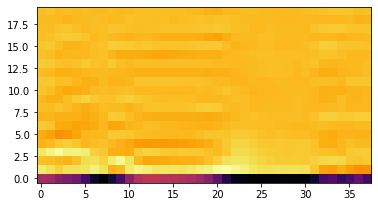

In [17]:
# 내가 확인 할 부분
idx = 1

# Create path from given filename and target item
path = '/'.join([dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx]])

# mfcc 만들기
mfccs = get_librosa_mfcc(path)

# MFCC 그림으로 보기
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# 소리 확인
# print(target_list[int(y_orig_train[idx])])
# print(path)
# playsound(path)

In [18]:
# 학습 하기 전에 미리 모든 소리에 대해서 feature 추출해서 준비 해두는 단계, inpu을 맞추려고 
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = "/".join([dataset_path, target_list[int(in_y[index])], 
                    filename])
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = get_librosa_mfcc(path)
        print(mfccs.shape)

        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [19]:
x_train, y_train, prob_train = extract_features(filenames_train, y_orig_train)
x_val, y_val, prob_val = extract_features(filenames_val, y_orig_val)
x_test, y_test, prob_test = extract_features(filenames_test, y_orig_test)

print("Train 잃은거{}".format(prob_train / len(y_orig_train)))
print("Valid 잃은거{}".format(prob_val / len(y_orig_val)))
print("Test 잃은거{}".format(prob_test / len(y_orig_test)))

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-3.0517578e-05  0.0000000e+00  3.0517578e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-1.5349760e-02 -1.6172053e-02 -2.2888849e-02 ...  2.2137112e-11
 -1.1717506e-11  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00274658  0.00143433  0.00076294 ... -0.00085449  0.0010

sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (47788,)
length: 2.98675 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (47788,)
length: 2.98675 secs
(20, 38)
sr: 16000 , sig shape: (48641,)
length: 3.0400625 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00234985 -0.00796509  0.00253296 ... -0.00292969  0.00714111
  0.00015259], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.02203369 -0.01589966 -0.00790405 ... -0.00143433  0.00024414
 -0.00036621], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 7.1190862e-04  1.4293985e-03  3.7318183e-04 ... -2.3045261e-06
  9.0480688e-07  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pas

(20, 38)
sr: 16000 , sig shape: (48641,)
length: 3.0400625 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 1.4886714e-04  1.4071017e-04 -9.3109675e-06 ...  3.8913084e-05
 -4.0715381e-06  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.02983066 -0.03118714 -0.03322427 ...  0.          0.
  0.        ], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[0.01531982 0.0161438  0.02288818 ... 0.         0.         0.        ], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (34134,)
length: 2.133375 secs
(20, 38)
sr: 16000 , sig shape: (41388,)
length: 2.58675 secs
(20, 38)
sr: 16000 , sig shape: (46934,)
length: 2.933375 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (48214,)
length: 3.013375 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-8.8970650e-05 -9.7564371e-05 -4.8216014e-05 ...  3.1861928e-05
 -4.4911649e-05  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 6.1035156e-05  9.1552734e-05  3.0517578e-05 ... -6.1035156e-05
  3.0517578e-05  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 4.7424316e-02  5.6884766e-02  4.8156738e-02 ...  1.0681152e-03
  6.1035156e-05 -2.1667480e-03], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykerne

sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.05253606  0.05225622  0.04543332 ... -0.00262159  0.00021528
 -0.00156788], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00076294 -0.00378418 -0.00527954 ... -0.00662231  0.00033569
  0.00512695], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00436401 -0.00112915 -0.00952148 ...  0.00778198 -0.00195312
  0.00180054], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)
sr: 16000 , sig shape: (41388,)
length: 2.58675 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (31745,)
length: 1.9840625 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00952029 -0.00011234 -0.00777477 ...  0.          0.
  0.        ], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05 -3.0517578e-05 ... -3.0517578e-05
  0.0000000e+00  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00128174 -0.00100708 -0.00192261 ...  0.0015564  -0.00091553
  0.00189209], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 4.

sr: 16000 , sig shape: (51883,)
length: 3.2426875 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-3.6913613e-04 -3.3435039e-04 -2.7817322e-04 ... -1.3519132e-06
  7.4513974e-07  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00045776  0.00442505  0.00448608 ...  0.00192261 -0.00457764
  0.0022583 ], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)
sr: 16000 , sig shape: (46934,)
length: 2.933375 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (51883,)
length: 3.2426875 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (41388,)
length: 2.58675 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[2.6409436e-05 3.5782690e-05 1.3560666e-05 ... 9.1319607e-06 5.5717201e-06
 0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 1.4251637e-05 -1.3516690e-05 -3.2523560e-05 ...  8.7318000e-13
 -2.5943627e-13  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.01361084  0.00860596 -0.00637817 ... -0.0017395  -0.003479
  0.00106812], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.02001953 -0.01422119 -0.02032471 ...  0.00579834 -0.00106812
 -0.00021362], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


2.389375 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (31745,)
length: 1.9840625 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)
sr: 16000 , sig shape: (44800,)
length: 2.8 secs
(20, 38)
sr: 16000 , sig shape: (31745,)
length: 1.9840625 secs
(20, 38)
sr: 16000 , sig shape: (41388,)
length: 2.58675 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.021698   -0.01370239 -0.02227783 ... -0.00106812 -0.00341797
  0.00057983], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00115967 -0.0022583  -0.00234985 ... -0.00222778  0.00201416
 -0.00057983], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (49153,)
length: 3.0720625 secs
(20, 38)
sr: 16000 , sig shape: (48641,)
length: 3.0400625 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (49153,)
length: 3.0720625 secs


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 2.8709512e-05  2.6054471e-05 -3.1274506e-06 ... -3.8674017e-08
  3.8383355e-08  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-3.0517578e-05 -3.0517578e-05  0.0000000e+00 ...  6.7138672e-04
 -1.2207031e-03 -9.1552734e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00292969  0.00335693 -0.01449585 ...  0.01544189 -0.0038147
  0.00631714], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)
sr: 16000 , sig shape: (48641,)
length: 3.0400625 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.0166626  -0.01937866 -0.02145386 ...  0.00411987 -0.00515747
 -0.00100708], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-3.6274724e-07  2.7239896e-05  8.2566421e-06 ...  2.6230900e-06
 -1.3001563e-06  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (34134,)
length: 2.133375 secs
(20, 38)
sr: 16000 , sig shape: (47788,)
length: 2.98675 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (49153,)
length: 3.0720625 secs
(20, 38)
sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)
sr: 16000 , sig shape: (47788,)
length: 2.98675 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (47788,)
length: 2.98675 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00076294  0.00897217  0.00402832 ...  0.00656128 -0.00442505
 -0.00067139], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.05255127 -0.05227661 -0.04544067 ...  0.00259399 -0.00024414
  0.0015564 ], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00057983 -0.00125122  0.00082397 ... -0.00231934  0.0007019
 -0.0020752 ], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00466919 -0.00411987 -0.00164795 ...  0.00045776 -0.00323486
  0.00076294], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00219727 -0.00405884 -0.00723267 ...  0.00268555  0.00588989
 -0.00457764], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (44800,)
length: 2.8 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (41388,)
length: 2.58675 secs
(20, 38)
sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.0043335   0.00387573  0.00088501 ...  0.01043701  0.00262451
  0.00112915], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00918579  0.01065063 -0.0012207  ... -0.0022583   0.00402832
 -0.00137329], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (46934,)
length: 2.933375 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (51883,)
length: 3.2426875 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr:

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.04904175  0.04925537  0.04125977 ... -0.00601196 -0.00576782
 -0.00601196], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (48641,)
length: 3.0400625 secs
(20, 38)
sr: 16000 , sig shape: (31745,)
length: 1.9840625 secs
(20, 38)
sr: 16000 , sig shape: (48214,)
length: 3.013375 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.01266479 -0.00143433 -0.00250244 ... -0.00564575  0.00076294
  0.00115967], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00341797 -0.00961304 -0.00238037 ... -0.00241089 -0.00982666
  0.00021362], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (48641,)
length: 3.0400625 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.01376343 -0.01300049 -0.02120972 ...  0.00402832 -0.00546265
 -0.00735474], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.01647949 -0.02145386 -0.0206604  ... -0.00042725 -0.00305176
  0.00024414], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (48641,)
length: 3.0400625 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (51883,)
length: 3.2426875 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (44800,)
length: 2.8 secs
(20, 38)
sr: 16000 , sig shape: (47788,)
length: 2.98675 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.01281738 -0.01837158 -0.02587891 ... -0.00579834  0.
 -0.00875854], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (49153,)
length: 3.0720625 secs
(20, 38)
sr: 16000 , sig shape: (48214,)
length: 3.013375 secs
(20, 38)
sr: 16000 , sig shape: (51883,)
length: 3.2426875 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00186157  0.00158691 -0.00387573 ...  0.0005188  -0.003479
  0.01107788], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.04980469  0.05532837  0.03942871 ...  0.00997925  0.00256348
 -0.00488281], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (44800,)
length: 2.8 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (48214,)
length: 3.013375 secs
(20, 38)
sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00665283 -0.00244141  0.00094604 ... -0.00708008  0.0045166
  0.00454712], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (48214,)
length: 3.013375 secs
(20, 38)
sr: 16000 , sig shape: (47788,)
length: 2.98675 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (34134,)
length: 2.133375 secs
(20, 38)
sr: 16000 , sig shape: (41388,)
length: 2.58675 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (34134,)
length: 2.133375 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00778198 -0.00067139 -0.00549316 ...  0.00418091  0.00286865
  0.00540161], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (51883,)
length: 3.2426875 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.04754639  0.05636597  0.04660034 ... -0.00445557  0.00384521
  0.00283813], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (51883,)
length: 3.2426875 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (44800,)
length: 2.8 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (48641,)
length: 3.0400625 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00421143  0.00497437  0.00198364 ... -0.00668335  0.00143433
  0.00158691], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.01190186 -0.00445557 -0.00061035 ...  0.00216675  0.00247192
 -0.00518799], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (46934,)
length: 2.933375 secs
(20, 38)
sr: 16000 , sig shape: (48214,)
length: 3.013375 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.05325317  0.06002808  0.04058838 ...  0.00222778 -0.00326538
 -0.00085449], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (49153,)
length: 3.0720625 secs
(20, 38)
sr: 16000 , sig shape: (47788,)
length: 2.98675 secs
(20, 38)
sr: 16000 , sig shape: (46934,)
length: 2.933375 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (44800,)
length: 2.8 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.0597229   0.05187988  0.04797363 ...  0.00161743  0.00033569
 -0.0017395 ], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.01367188 -0.01953125 -0.01879883 ...  0.00292969  0.00231934
 -0.00643921], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


(20, 38)
sr: 16000 , sig shape: (51883,)
length: 3.2426875 secs
(20, 38)
sr: 16000 , sig shape: (51883,)
length: 3.2426875 secs
(20, 38)
sr: 16000 , sig shape: (51883,)
length: 3.2426875 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (48641,)
length: 3.0400625 secs
(20, 38)
sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)
sr: 16000 , sig shape: (34134,)
length: 2.133375 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (48214,)
length: 3.013375 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00360107 -0.00183105 -0.00119019 ... -0.00045776  0.00170898
  0.01309204], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00537109 -0.01361084 -0.01303101 ... -0.0062561   0.00552368
  0.00097656], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00283813  0.0038147  -0.003479   ... -0.00585938  0.00741577
 -0.00372314], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00024414  

sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (47788,)
length: 2.98675 secs
(20, 38)
sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00393677  0.00021362  0.00866699 ... -0.0050354   0.0010376
  0.00088501], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00158691 -0.00476074  0.00299072 ...  0.00210571 -0.00332642
  0.00332642], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (37547,)
length: 2.3466875 secs
(20, 38)
sr: 16000 , sig shape: (51883,)
length: 3.2426875 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[-0.00057983 -0.00772095 -0.00714111 ... -0.01116943 -0.00820923
 -0.00396729], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (27307,)
length: 1.7066875 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.0140686   0.012146   -0.00570679 ...  0.0027771  -0.00030518
  0.00396729], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (33110,)
length: 2.069375 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.01428223 -0.00015259  0.00448608 ...  0.00424194 -0.00036621
 -0.00354004], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (38571,)
length: 2.4106875 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs
(20, 38)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.00378418 -0.00054932 -0.00054932 ...  0.00256348  0.00369263
  0.00476074], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


sr: 16000 , sig shape: (31745,)
length: 1.9840625 secs
(20, 38)
sr: 16000 , sig shape: (51883,)
length: 3.2426875 secs
(20, 38)
sr: 16000 , sig shape: (38230,)
length: 2.389375 secs


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Pass y=[ 0.01119995  0.00170898 -0.01348877 ...  0.00537109 -0.00289917
 -0.00045776], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


(20, 38)
sr: 16000 , sig shape: (38913,)
length: 2.4320625 secs
(20, 38)
sr: 16000 , sig shape: (35840,)
length: 2.24 secs
(20, 38)
Train 잃은거0.0
Valid 잃은거0.0
Test 잃은거0.0


In [20]:
print(np.array(x_train).shape)
print(np.array(y_train).shape)
print(np.array(x_val).shape)
print(np.array(y_val).shape)
print(np.array(x_test).shape)
print(np.array(y_test).shape)

(159, 20, 38)
(159,)
(53, 20, 38)
(53,)
(53, 20, 38)
(53,)


In [21]:
# 학습에 사용할 모든 - MFCC 까지 모두 진행한 정보들
#저장 할 곳
np.savez(base_path +"mfcc_set.npz", 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

# 모델 학습

In [22]:
# 나중에 저장할 모델 - 2진 분류
model_filename = 'hi_yutan_original_model.h5'
wake_word = 'hi_yutan'
feature_sets = np.load( base_path + "mfcc_set.npz")

# 저장되어 있는 mfcc feature 들 불러 오기
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [23]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(159, 20, 38)
(53, 20, 38)
(53, 20, 38)


In [24]:
# 내가 수행 하고 싶은 "기동어" 설정
# index (나는 하나니까 0) 이면, True 또는 False 반환 해주기 - 1아니면 0 ]
wake_word_index = target_list.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')
print(wake_word_index)

0


In [25]:
# CNN 에 넣기 이전에 Channel을 1로 만들어주기

x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

sample_shape = x_test.shape[1:]
print(sample_shape)

(159, 20, 38, 1)
(53, 20, 38, 1)
(53, 20, 38, 1)
(20, 38, 1)


In [26]:
# 모델 Conv-layer 
conv_layer = keras.Sequential([
                             layers.Conv2D(32, (3,3), activation = 'relu', input_shape = sample_shape,padding='same'),
                             layers.MaxPooling2D(pool_size=(3, 3)),
                             layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
                             layers.MaxPooling2D(pool_size=(3, 3)),
                             layers.Conv2D(128, (3, 3), activation='relu',padding='same'),
                             layers.MaxPooling2D(pool_size=(3, 3),padding='same')
                             ])


# FC layer는 다른거 사용   --  Class 10 개 분류
fc_layer = keras.Sequential([
                             layers.Flatten(),
                             layers.Dense(128, activation = 'relu'),
                             layers.Dropout(0.5),
                             layers.Dense(128, activation = 'relu'),
                             layers.Dropout(0.5),
                             layers.Dense(1, activation = "sigmoid")
                             ])

model = keras.Sequential([conv_layer,
                          fc_layer
                          ])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1, 2, 128)         92672     
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 49537     
Total params: 142,209
Trainable params: 142,209
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Callback 함수 지정 해주기      학습하는 동안 설정해줄것
early_stop = EarlyStopping(patience=30) 
mc = ModelCheckpoint(base_path + "best_model/wake_up_word_model", 
                     save_best_only=True,
                     monitor = 'val_loss',
                     verbose = 1,
                     mode = 'min') 
reduce_lr  = ReduceLROnPlateau(monitor = 'val_loss',
                               factor=0.5, 
                               patience=5
                               ) 

#optimizer 조정 해주기
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [28]:
# optimizer, loss 함수를 정의하고,  학습 준비를 한다,  metrics 는 어떤 일이 발생하는지 보여줄 것들
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

# 한번에 몇개의 데이터 학습하고 가중치 갱신할지 
history = model.fit(x_train, y_train,
          epochs=100,
          verbose=1,
          batch_size=64,
          #validation_split = 0.1
          validation_data = (x_val, y_val),
          callbacks = [early_stop, reduce_lr , mc]
          )

Epoch 1/100
3/3 [==============================] - 12s 292ms/step - loss: 9.6142 - accuracy: 0.5031 - val_loss: 2.2497 - val_accuracy: 0.7925

Epoch 00001: val_loss improved from inf to 2.24970, saving model to ./best_model\wake_up_word_model
INFO:tensorflow:Assets written to: ./best_model\wake_up_word_model\assets
Epoch 2/100
3/3 [==============================] - 0s 25ms/step - loss: 7.0060 - accuracy: 0.6101 - val_loss: 3.0235 - val_accuracy: 0.7925

Epoch 00002: val_loss did not improve from 2.24970
Epoch 3/100
3/3 [==============================] - 0s 28ms/step - loss: 4.5397 - accuracy: 0.6918 - val_loss: 2.9032 - val_accuracy: 0.7925

Epoch 00003: val_loss did not improve from 2.24970
Epoch 4/100
3/3 [==============================] - 0s 30ms/step - loss: 3.5329 - accuracy: 0.7107 - val_loss: 2.3049 - val_accuracy: 0.7925

Epoch 00004: val_loss did not improve from 2.24970
Epoch 5/100
3/3 [==============================] - 0s 28ms/step - loss: 3.8417 - accuracy: 0.7170 - val_los

3/3 [==============================] - 0s 28ms/step - loss: 0.1760 - accuracy: 0.9119 - val_loss: 0.0098 - val_accuracy: 1.0000

Epoch 00032: val_loss did not improve from 0.00893
Epoch 33/100
3/3 [==============================] - 0s 26ms/step - loss: 0.0979 - accuracy: 0.9560 - val_loss: 0.0097 - val_accuracy: 1.0000

Epoch 00033: val_loss did not improve from 0.00893
Epoch 34/100
3/3 [==============================] - 0s 25ms/step - loss: 0.1090 - accuracy: 0.9308 - val_loss: 0.0096 - val_accuracy: 1.0000

Epoch 00034: val_loss did not improve from 0.00893
Epoch 35/100
3/3 [==============================] - 0s 26ms/step - loss: 0.2142 - accuracy: 0.9371 - val_loss: 0.0095 - val_accuracy: 1.0000

Epoch 00035: val_loss did not improve from 0.00893
Epoch 36/100
3/3 [==============================] - 0s 28ms/step - loss: 0.2172 - accuracy: 0.9308 - val_loss: 0.0096 - val_accuracy: 1.0000

Epoch 00036: val_loss did not improve from 0.00893
Epoch 37/100
3/3 [==============================

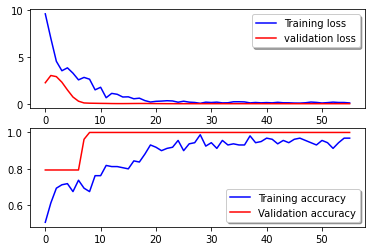

In [29]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color = 'b', label = "Training loss")
ax[0].plot(history.history['val_loss'], color='r', label = "validation loss", axes = ax[0])
legend = ax[0].legend(loc='best', shadow = True)

ax[1].plot(history.history['accuracy'], color = 'b', label = "Training accuracy")
ax[1].plot(history.history['val_accuracy'], color = 'r', label = "Validation accuracy")
legend = ax[1].legend(loc = 'best', shadow = True)

In [30]:
# 학습한거에서 test 어떻게 나오는지 확인 해보기
model = tf.keras.models.load_model(base_path + 'best_model/wake_up_word_model')
for i in range(0, 5):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 1.0  Prediction: [[0.9558532]]
Answer: 0.0  Prediction: [[0.00205266]]
Answer: 1.0  Prediction: [[0.9998641]]
Answer: 1.0  Prediction: [[0.99999845]]
Answer: 0.0  Prediction: [[0.00026757]]


In [31]:
loss, acc = model.evaluate(x=x_test, y=y_test)
print("loss=",loss)
print("acc=",acc)

2/2 [==============================] - 0s 100ms/step - loss: 0.0138 - accuracy: 1.0000
loss= 0.01378153171390295
acc= 1.0


In [32]:
print(x_test.shape, y_test.shape)
print(y_test)

(53, 20, 38, 1) (53,)
[1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1.]


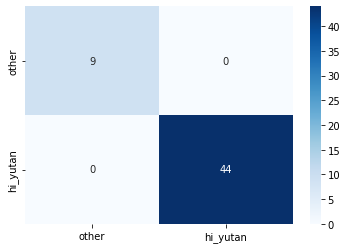

Test Accureacy:  1.0
Test Precision:  1.0
Test Recall:  1.0
Test F1 score:  1.0
Val 에서 1의 비율 : 79.25%
Test 에서 1의 비율 : 83.02%


In [33]:
Y_pred = model.predict(x_test)


thres_hold = 0.5
predictions = []
for result in Y_pred:
  if result > thres_hold:
      predictions.append(1)
  else:
      predictions.append(0)



label = ["other", "hi_yutan"]

confusion_mtx = metrics.confusion_matrix(y_test,predictions)
sns.heatmap(confusion_mtx,
            annot=True,
            xticklabels = label,
            yticklabels = label,
            cmap='Blues')
plt.show()

print('Test Accureacy: ',metrics.accuracy_score( y_test,predictions))
print('Test Precision: ',metrics.precision_score( y_test,predictions))
print('Test Recall: ',metrics.recall_score( y_test,predictions ))
print('Test F1 score: ',metrics.f1_score(y_test,predictions ))
print("Val 에서 1의 비율 : {}%".format(  round(list(y_val).count(1) / len(y_val)*100 , 2 )))
print("Test 에서 1의 비율 : {}%".format(  round(list(y_test).count(1) / len(y_test)*100 , 2 )))




# tflite 변환 해주기 / 평가

In [39]:
tflite_file_path = base_path + 'tflite_model/wake_word_hi_yutan_lite.tflite'

model = tf.keras.models.load_model(base_path + 'best_model/wake_up_word_model')
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(tflite_file_path, 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\yutan\AppData\Local\Temp\tmptfovkohx\assets


INFO:tensorflow:Assets written to: C:\Users\yutan\AppData\Local\Temp\tmptfovkohx\assets


573484

In [40]:
tflite_file_path = base_path + 'tflite_model/wake_word_hi_yutan_lite.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_file_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

[{'name': 'sequential_input', 'index': 0, 'shape': array([ 1, 20, 38,  1]), 'shape_signature': array([-1, 20, 38,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 24, 'shape': array([1, 1]), 'shape_signature': array([-1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [41]:
# tflite 모델 평가에서 사용되는 실행 함수
thres_hold = 0.9
def run_tflite_model(tflite_file, test_image_indices):
  global x_test
  global y_test

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = x_test[test_image_index]
    test_label = y_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    # thres_hold 설정 해주기

    if output > thres_hold:
      output = 1
    else:
      outut = 0

    predictions[i] = output

  return predictions

In [42]:
def evaluate_model(tflite_file, model_type):
  global test_x
  global test_y

  test_image_indices = range(x_test.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)
  accuracy = (np.sum(y_test.reshape(-1)== predictions) * 100) / len(x_test)

  confusion_mtx = tf.math.confusion_matrix(y_test, predictions)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (model_type, accuracy, len(x_test)))

  
  label = ["other", "hi_yutan"]
  sns.heatmap(confusion_mtx,
            annot=True,
            xticklabels = label,
            yticklabels = label,
            cmap='Blues')
  plt.show()
  
  print("Thres - hold : {}".format(thres_hold))
  print('Test Accureacy: ',metrics.accuracy_score( y_test,predictions))
  print('Test Precision: ',metrics.precision_score( y_test,predictions))
  print('Test Recall: ',metrics.recall_score( y_test,predictions ))
  print('Test F1 score: ',metrics.f1_score(y_test,predictions ))
  print("Val 에서 1의 비율 : {}%".format(  round(list(y_val).count(1) / len(y_val)*100 , 2 )))
  print("Test 에서 1의 비율 : {}%".format(  round(list(y_test).count(1) / len(y_test)*100 , 2 )))





Float model accuracy is 100.0000% (Number of test samples=53)


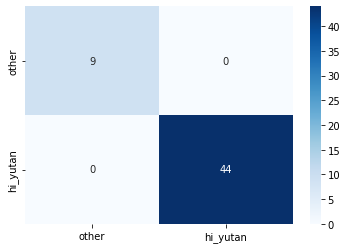

Thres - hold : 0.9
Test Accureacy:  1.0
Test Precision:  1.0
Test Recall:  1.0
Test F1 score:  1.0
Val 에서 1의 비율 : 79.25%
Test 에서 1의 비율 : 83.02%


In [43]:
evaluate_model(tflite_file_path, model_type="Float")
# 세로 - True
# 가로 - Prediction

# 추론 과정

In [103]:
# 기본 형태
import pyaudio
import numpy as np
 
CHUNK = 2**10  # 음성 데이터 불러올때, 한번에 몇개의 정수를 불러올지
RATE = 44100   # 음성 데이터의 sampleing rate , mfcc 에 나오는 거라 다른거니까 구분 해두기

# 음성 데이터 스트리을 여는 코드
"""
foramt : 비트 깊이를 설정 ,   여기서는 16bit가 된다
input : 우리가 지금 열려고 하는 것이기 떄문에 True
frames_per_buffer : 한번에 몇개의 정수를 불러올지
input_device_index : 원하는 입력 장치의 번호 (이거 없으면 자동으로 설정 해준다..)
"""
p=pyaudio.PyAudio()
stream=p.open(format=pyaudio.paInt16,channels=1,rate=RATE,input=True,
              frames_per_buffer=CHUNK,input_device_index=2)
 
# 음성 데이터를 입력받아 출력하는 소스
while(True):
    data = np.fromstring(stream.read(CHUNK),dtype=np.int16)
    print(int(np.average(np.abs(data))))
 
stream.stop_stream()
stream.close()
p.terminate()


ModuleNotFoundError: ignored

In [ ]:
"""
Connect a resistor and LED to board pin 8 and run this script.
Whenever you say "stop", the LED should flash briefly
"""

import sounddevice as sd
import numpy as np
import scipy.signal
import timeit
import python_speech_features
import RPi.GPIO as GPIO

from tflite_runtime.interpreter import Interpreter

# Parameters
debug_time = 1
debug_acc = 0
led_pin = 8
word_threshold = 0.5
rec_duration = 0.5 # 기동어 말 평균 길이로 하면 될듯 함
window_stride = 0.5 # 이거는 유지 해주기
sample_rate = 48000
resample_rate = 8000
num_channels = 1
num_mfcc = 40
model_path = base_path + 'wake_word_hi_yutan_lite.tflite'

# Sliding window
window = np.zeros(int(rec_duration * resample_rate) * 2)

# GPIO 
GPIO.setwarnings(False)
GPIO.setmode(GPIO.BOARD)
GPIO.setup(8, GPIO.OUT, initial=GPIO.LOW)

# Load model (interpreter)
interpreter = Interpreter(model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

# Decimate (filter and downsample)
def decimate(signal, old_fs, new_fs):
    
    # Check to make sure we're downsampling
    if new_fs > old_fs:
        print("Error: target sample rate higher than original")
        return signal, old_fs
    
    # We can only downsample by an integer factor
    dec_factor = old_fs / new_fs
    if not dec_factor.is_integer():
        print("Error: can only decimate by integer factor")
        return signal, old_fs

    # Do decimation
    resampled_signal = scipy.signal.decimate(signal, int(dec_factor))

    return resampled_signal, new_fs

# This gets called every 0.5 seconds
def sd_callback(rec, frames, time, status):

    GPIO.output(led_pin, GPIO.LOW)

    # Start timing for testing
    start = timeit.default_timer()
    
    # Notify if errors
    if status:
        print('Error:', status)
    
    # Remove 2nd dimension from recording sample
    rec = np.squeeze(rec)
    
    # Resample
    rec, new_fs = decimate(rec, sample_rate, resample_rate)
    
    # Save recording onto sliding window
    window[:len(window)//2] = window[len(window)//2:]
    window[len(window)//2:] = rec

    # Compute features
    mfccs = python_speech_features.base.mfcc(window, 
                                        samplerate=new_fs,
                                        winlen=0.256,
                                        winstep=0.050,
                                        numcep=num_mfcc,
                                        nfilt=26,
                                        nfft=2048,
                                        preemph=0.0,
                                        ceplifter=0,
                                        appendEnergy=False,
                                        winfunc=np.hanning)
    mfccs = mfccs.transpose()

    # Make prediction from model
    in_tensor = np.float32(mfccs.reshape(1, mfccs.shape[0], mfccs.shape[1], 1))
    interpreter.set_tensor(input_details[0]['index'], in_tensor)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    val = output_data[0][0]
    if val > word_threshold:
        print('stop')
        GPIO.output(led_pin, GPIO.HIGH)

    if debug_acc:
        print(val)
    
    if debug_time:
        print(timeit.default_timer() - start)

# Start streaming from microphone
with sd.InputStream(channels=num_channels,
                    samplerate=sample_rate,
                    blocksize=int(sample_rate * rec_duration),  # 1초에 프레임 * 녹화 하는 기간
                    callback=sd_callback):
    while True:
        pass

# TEMP

In [ ]:
"""
1.	D기동어 인식 개요
    1.	음성 인식 서비스 사례 – 케이티, 카카오, 구글 등 음성 인식 서비스 있음
    2.	문제점 및 해결 방안 – 서버에서 음성을 계속 받으면 비효율적 -> 기동어를 통해 서버와의 연결 제어
2.	Audio Processing
    1.	음성 신호 특성
    2.	Fourrier Transform (각 주파수 대역별에서의 에너지 크기 측정)
3.	기동어 인식 시스템 구조
4.	Mel Frequency Cepstral Coefficient (MFCC) 
    1.	Pe-emphasis
    2.	Fast Fourier Transform (FFT) – 위에 FT랑 다르게 프레임으로 쪼개어 변환 함 -> Spectrum  계획
        1.	Frequency domain의 feature를 형성, 보통 10 ~ 25ms 을 기준으로 함
        2.	Frame 간의 간격 = 5 ~ 10ms 로 설정
        3.	Frame 만들때 보통 Hamming Window를 통해 연속성 확보
        4.	Discrete Fourier Transorm(DFT)로  frame별 feature 추출  (주파수 별, 에너지 얼마나 있나)
    3.	Mel Spectrum ( 인간의 귀를 따라 만든 Mel-Filter Bank를 적용해서 Mel Spectrum 추출)
        1.	사람이 잘 들을 수 있는 저주파 영역을 확장
        2.	위에서 나온 DFT는 각 주파수에 해당하는 에너지 양을 보여줌
        3.	여기에다 고막의 특성을 적용(log를 통해) 하기 위해 Mel Filter Bank(각 주파수 별로 에너지 모음) 적용
        4.	이거를 DFT의 결과로 나온 주파수에 맞게 곱해줘서 나온 값에, Log를 적용(사람 귀)
    4.	Cepstral Analysis
        1.	Discrete Cosine Transform(DCT)을 통해 smoothing된 Fourier Transform 값 추출
        2.	3번까지 Frequency에 대한 값이지만, 다시 시간에 대한 값으로 표현
        3.	FFT 보다 연속성을 잘 표현 가능 (더 Smoothing 되었기 때문에 )
        4.	여기서 나온 값에서 첫 12개의(선택) MFCC Vector를 추출
    5.	MFCC Feature 생성ㅇㄹ
        1.	위 과정에서 나온거 중에 저주파(coefficient) 구간을 몇 개(N)를 볼 것인지 선택
5.	Deep Learning
6.	차주 계획

"""

In [ ]:
"""
# MFCC 추출 해주기
# https://blog.naver.com/PostView.nhn?isHttpsRedirect=true&blogId=sooftware&logNo=221661644808 참고

# frame 개수를 보여줌, output 세로
num_mfcc = 25
# output 가로
len_mfcc = 41
# input 음향 뒤에서 얼마나 잘라줄지
sample_cut = 20000

def get_librosa_mfcc(filepath):
  sampling_rate = 16000  # 1초에 몇개의 signal이 들어가 있는가
  hop_len = 500  # sig / hop_len 만큼 크기의 output 이 나옴
   # 들어오는 음향 길이 설정
  sig, sr = librosa.core.load(filepath, sampling_rate)
  # 뒤에서 부터 자르는게 더 좋을거 같음
  input_sig = sig[-sample_cut:]
  print("signal 크기 :",sig.shape)
  # log mell 찾아 보기
  # 120 만큼은 겹치게 된다.
  mfccs = librosa.feature.mfcc(y = input_sig, sr = sr, hop_length =hop_len, n_mfcc = num_mfcc, n_fft = 512 )
  return mfccs



print("Model input size = ( {} x {} x {})".format(num_mfcc, len_mfcc, 1))


# n_mfcc : 음성데이터를 어느 단위로 쪼갤지 (사람은 20 ~ 40 ms 까지는 음소가 바뀌지 못함 - 말 자르는 가장 작은 단위 == frame_size
# n_fft : frame의 length = window size,   잘린 음석이 n_ftt보다 작으면 0으로 Padding 해줌, 
   # n_fft는 winddow size보다 크거나 같아야함
   # n_ftt = 8000 * 0.040 = 320
# hop_legth : window 얼마 만큼씩 움질일 것인가

  # n_mfcc = 40
  # hop_length = 200  # 8000 * 0.040
  # N_FFT = 320    # 8000 * 0.040

# 이거 기준으로 나눈 다음에 Mel값을 뽑아서 Feature로 사용하게 된다.  (  50%는 겹치게 분할을 진행)
# 각각의 frame에 대해서 Hamming Window 적용해서 연속성 맞춰주기 - Default 설정임
# 각 프레임에 대하여 Fourier Transform 적용해서(FFT) 주파서 성분 알아내기
# Mel Filter Banb(삶귀처럼, 주파수 증가할수록 큰 삼각형 filter가 생각다고 생각하기)
# 여기까지하면 Mel-Spectrogram Feature가 추출된다.

# Mel-Spectrogram 을 압축해서 표현해주는 DCT 연산 수행 -> Discrete Cosine Transform
"""


Model input size = ( 25 x 41 x 1)
